In [2993]:
%load_ext autoreload
%load_ext google.cloud.bigquery
%autoreload 2

from dotenv import find_dotenv, load_dotenv
from sklearn.model_selection import StratifiedKFold
from src.data.get_dataset import Dataset
from src.features import build_features
from sklearn import svm
from src.features.build_features import Features
from src.models import train_model
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import json
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
random_state = 1234
load_dotenv(find_dotenv())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


True

In [2994]:
dataset = Dataset()
train_dataset, test_dataset = dataset.get_dataset()

In [2998]:
feature_builder = Features(train_dataset)
features = feature_builder.build_all_features()
categorical_features = [feature for feature in features.columns if 'manual_num' not in feature]
# select only features that we want
# features = features[['manual_cat_loan_amount', 
#                     'cat_loan_duration',
#                     'manual_cat_installment',
#                     'manual_cat_last_6m_median_cash',
#                     'manual_num_last_months_cash',
#                     'manual_num_cashflow_slope',
#                     'manual_num_cashflow_rsquared',
#                     'manual_cat_cashflow_downrate',
#                     'manual_cat_negative_ratio',
#                     'manual_cat_cashflow_stable',
#                     'manual_num_cashflow_intercept',
#                     'npwp',
#                     'ktp',
#                     'manual_num_monthly_income_in_milion',
#                     'merchant_type',
#                     'shop_type',
#                     'program_name',
#                     'num_of_banks',
#                      'shopee_user',
#                      'manual_cat_age',
#                     'manual_num_cashflow_slope_without_norm',
#                     'manual_cat_complaint_ratio',
#                     'manual_cat_negative_ratio',
#                     'manual_num_store_age',
#                     'bank_statement',
#                     'cat_pefindo_grade',
#                     'num_pefindo_score',
#                     'cat_due_amount',
#                     'cat_outstanding_amount',
#                     'valid_npwp_name']]
# # one hot encoding
# features = build_features.get_dummies(features, 
#                             [
#                             'manual_cat_age',
#                             'cat_pefindo_grade',
#                             'cat_loan_duration',
#                             'cat_outstanding_amount',
#                             'cat_due_amount'])
features = features[categorical_features]
# target = train_dataset['default']

/mnt/src/features/build_features.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  > 25, "manual_num_loan_amount_without_extreme"] = 25
/mnt/src/features/build_features.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.dataset['dueAmount'] = self.dataset['dueAmount'].astype(float).fillna(0)
/mnt/src/features/build_features.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

# Cross validation

train_auc  val_auc
0      0.946    0.752
1      0.947    0.680
2      0.947    0.713
3      0.942    0.700
4      0.947    0.680

train_auc   0.946
val_auc     0.705
dtype: float64

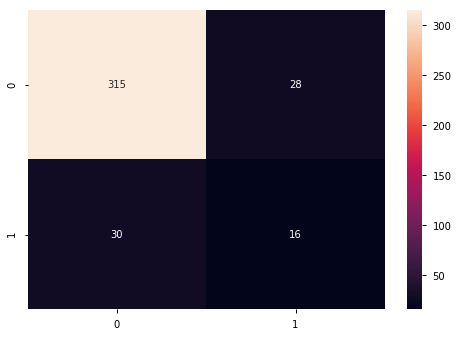

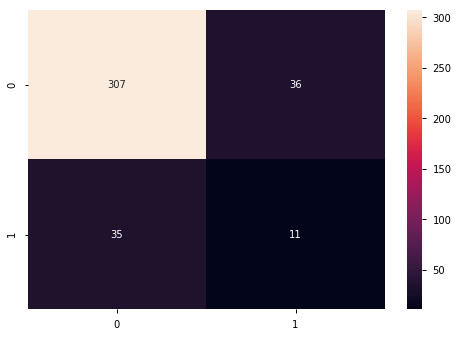

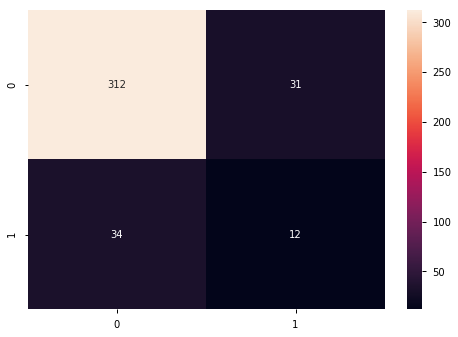

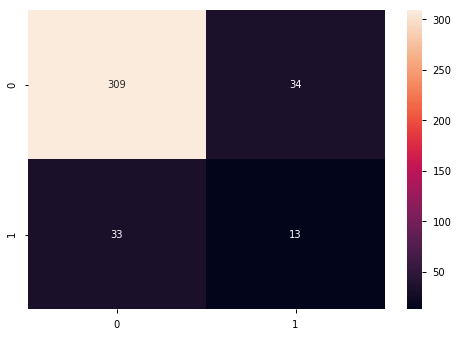

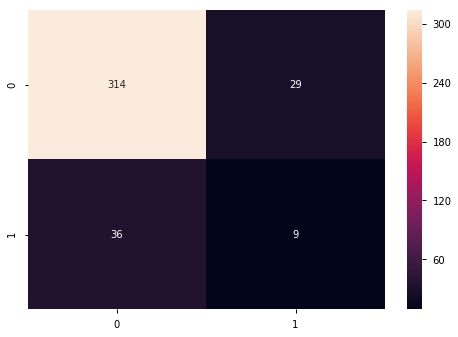

In [3003]:
model_rf = RandomForestClassifier(n_estimators=500, 
                                 max_features=0.2,
                                 max_depth=12,
                                 criterion='gini',
                                 oob_score=True,
                                 bootstrap=True,
                                 n_jobs=-1,
                                 min_samples_leaf = 5,
                                 max_leaf_nodes = 500,
                                 min_samples_split=50,
                                 class_weight='balanced'
                                )

result = train_model.cross_validate_model(model_rf, features.drop(['default'],1), 
                                          features['default'])
display(result)
result.mean()

<br/><br/><br/><br/><br/><br/>

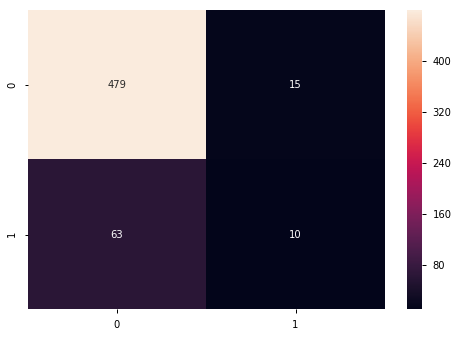

In [2910]:
x_train, x_val, y_train, y_val = train_test_split(train_encoded.drop(['default'], axis=1), 
                                                  train_encoded['default'],
                                                  shuffle=True,
                                                  stratify=train_encoded['default'],
                                                  test_size = .3,
                                                  random_state=12)
# oversampling
sampling = SVMSMOTE(sampling_strategy=0.7)
x_train_res, y_train_res = sampling.fit_sample(x_train, y_train)

ratio = float(np.sum(y_train_res == 0) / np.sum(y_train_res == 1))
clf_rf =  XGBClassifier()
clf_rf.fit(x_train_res, y_train_res)
y_train_scores = clf_rf.predict_proba(x_train_res.values)[:, 1]
print("   ",roc_auc_score(y_train_res,y_train_scores))
sns.heatmap(confusion_matrix(y_val, clf_rf.predict(x_val)), annot=True, fmt="d")

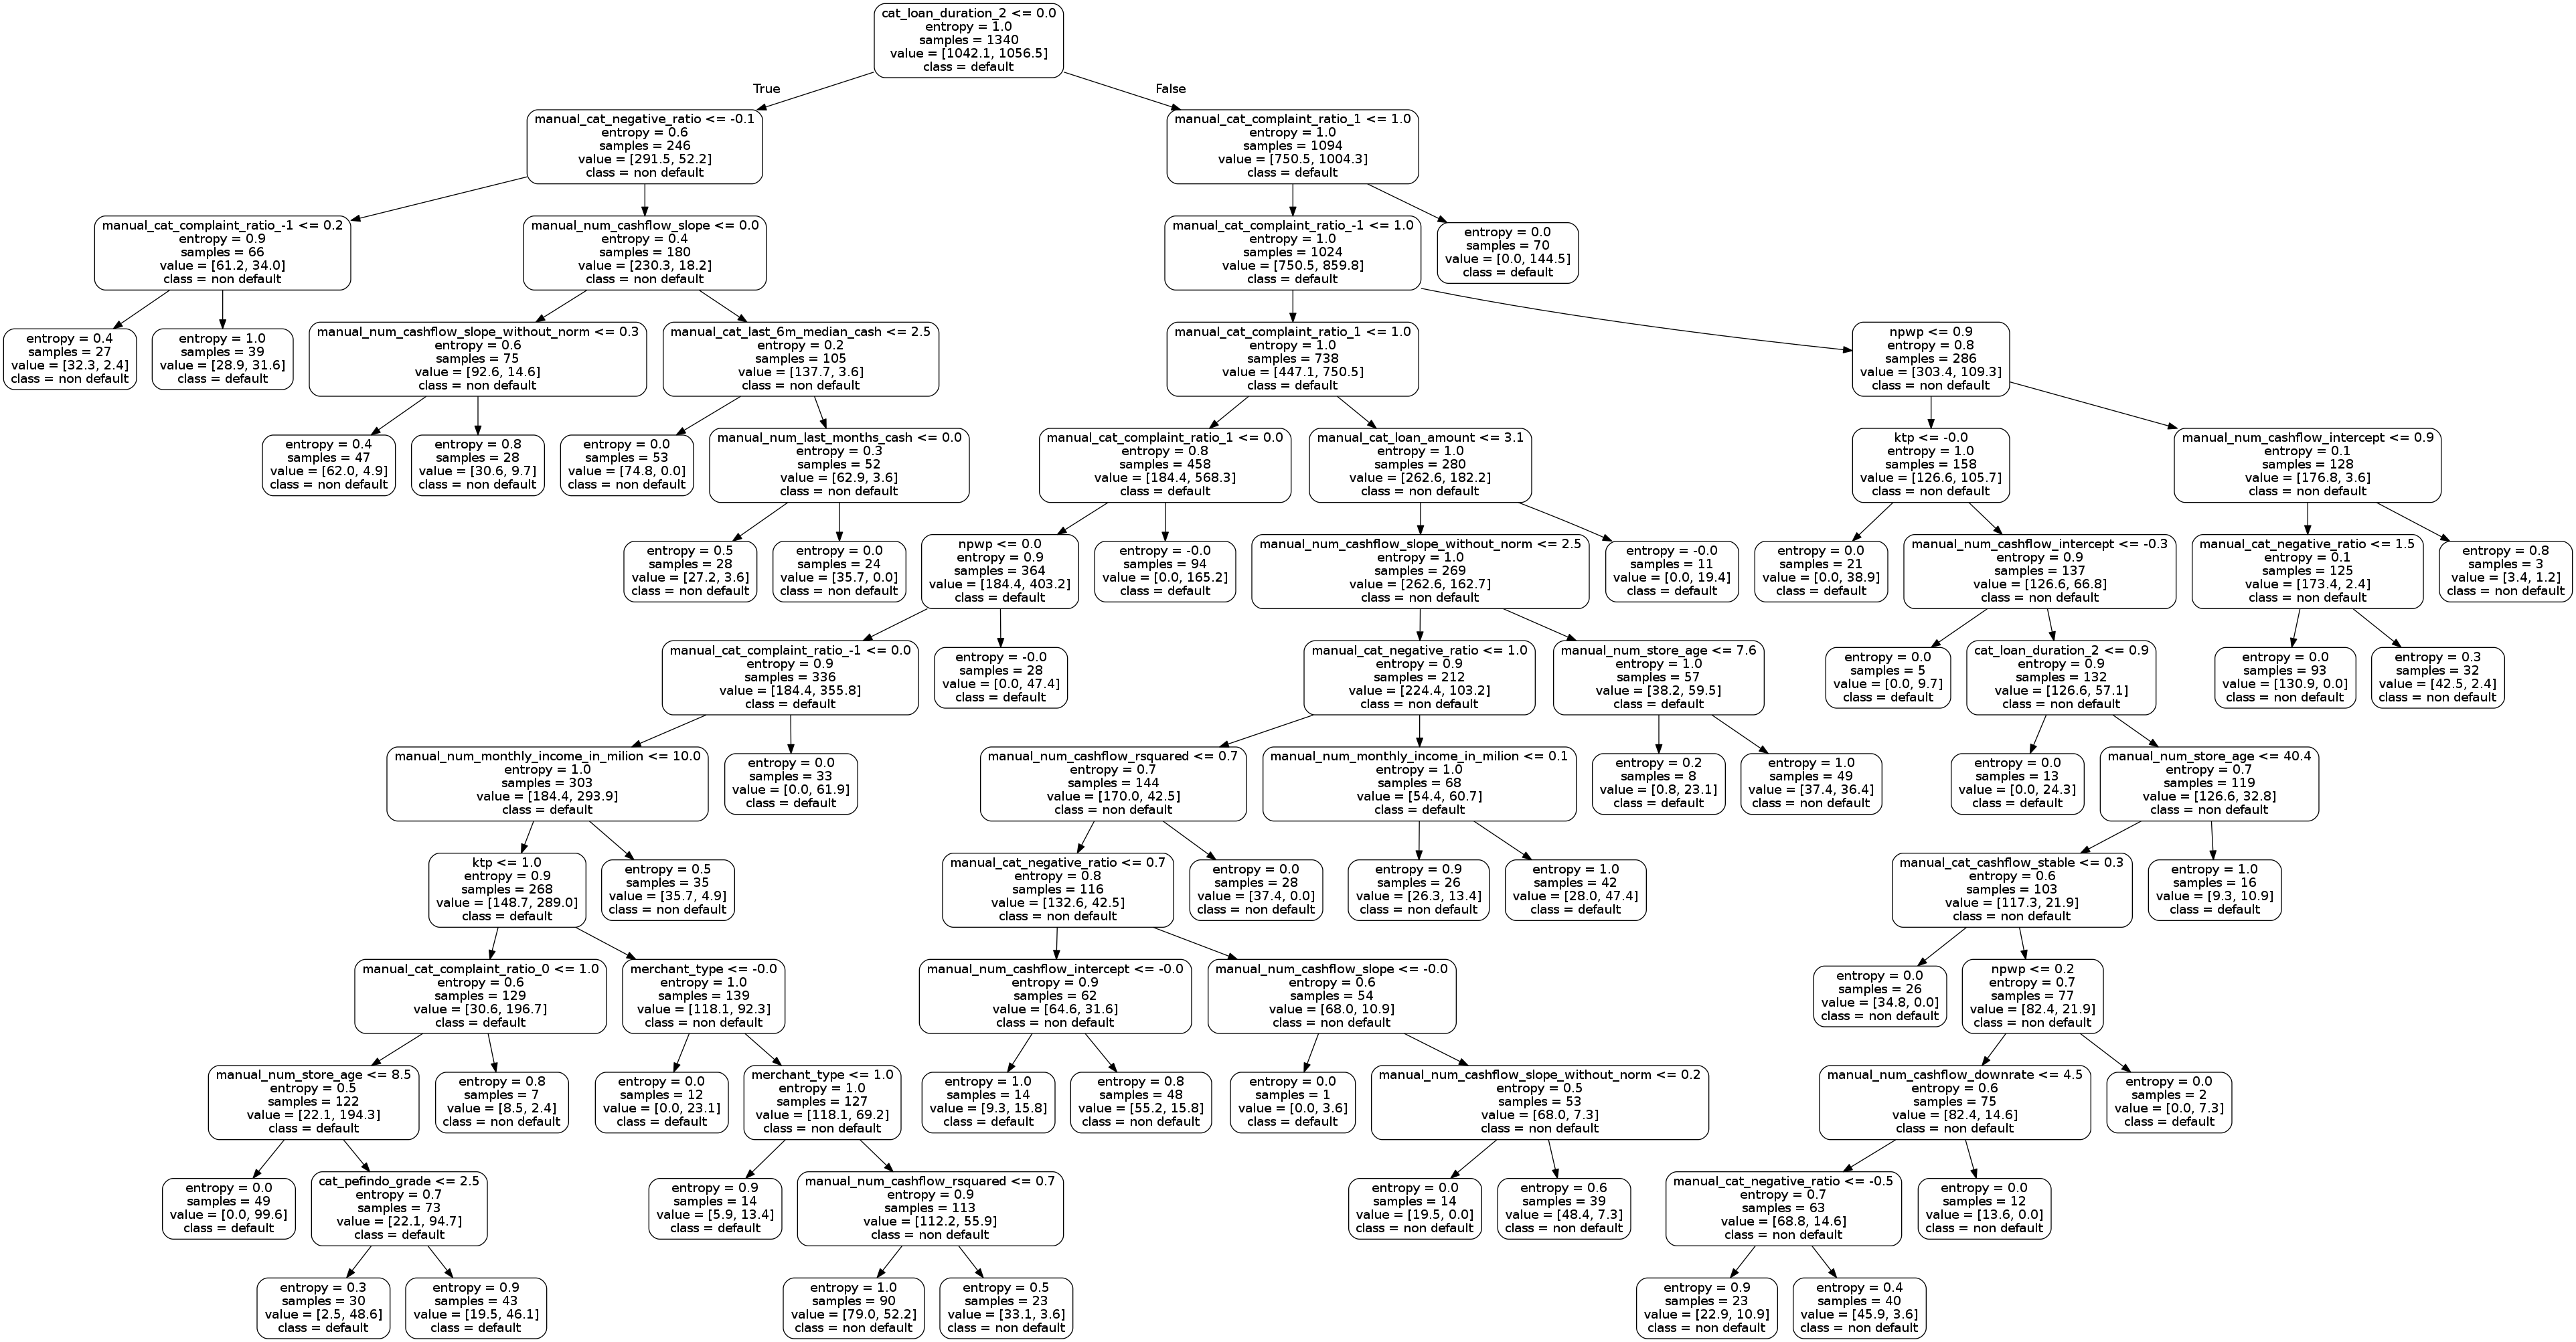

In [2992]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

# Import tools needed for visualization
from sklearn.tree import export_graphviz
# Pull out one tree from the forest
from random import randint
index = randint(0, 1000)
tree = model.estimators_[index]
dot_data = StringIO()
# Export the image to a dot file
export_graphviz(tree,out_file=dot_data,
                feature_names = x_train.columns, 
                rounded = True, 
                precision = 1,
                class_names=["non default", "default"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display(Image(graph.create_png()))